In [1]:
# Imports.
import sys
sys.path.append(r'C:\Users\edova\Documents\GitLab\ctrappy')
import ctrappy.diffusion
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
# Diffusion function to fit.
def fitfunc_log(tau, gen_diff, anom_exp):
    return np.log(gen_diff) + anom_exp * np.log(tau)


# Get anomalous diffusion fit using log transformation method from https://doi.org/10.1371/journal.pone.0117722
def get_anom_diff_fit(data_x_kbp, frame_time=5, sigma_error=0.066, threshold=0.0025, min_segment_size=3,
                      penalty=0.3, jump=1):
    
    t_array = np.array([frame_time * i for i in range(1, len(data_x_kbp + 1))])
    msd = ctrappy.diffusion.get_msd(data_x_kbp) - 2 * sigma_error ** 2
    t_array = t_array[msd > 0]
    msd = msd[msd > 0]
    if len(msd) > 5:

        msd_log = np.log(msd)
        # We need std(alpha) < 0.5 for reliable alpha histograms.
        # With these settings, 12 frames is enough according to simulations.
        best_fit = max(5, int(len(msd) * 0.33))
        best_fit = min(best_fit, 50)

        try:
            popt, pcov = curve_fit(fitfunc_log, t_array[:best_fit], msd_log[:best_fit],
                                   bounds=([0, 0], [np.inf, 2]), p0=(0.001, 1))
            anom_diff = popt[0]
            anom_exp = popt[1]
            return anom_diff, anom_exp

        except:
            print('Error during MSD fit.')
    else:
        print('Trace too short after noise removal.')
        
    return np.nan, np.nan            

In [3]:
# Trace simulation.
def simulate_trace(i, diff, vel, length, error, fps, dna_range_kbp=[3, 20]):
    base_loc = npr.rand() * (dna_range_kbp[1] - dna_range_kbp[0]) + dna_range_kbp[0]
    base_trace = npr.normal(base_loc, error, size=length)
    direction = np.random.choice([-1, 1])
    trace = np.arange(length) * vel / fps * direction + base_trace
    random_walk = npr.normal(0, np.sqrt(diff/fps), size=length)
    trace = trace + np.cumsum(random_walk)
    df_add = pd.DataFrame()
    df_add['x_kbp'] = np.array(trace)
    df_add['time_s'] = np.arange(length) / fps
    return df_add

In [4]:
# Simulation parameters.
diff_const = 0.02  # kbp^2/s
velocity = 0.05  # kbp/s
measurement_error = 0.072  # kbp
trace_length = 80
npr.seed(420)
frames_per_second = 1

# Make some traces.
df_diff = simulate_trace(512, diff_const, 0, trace_length, measurement_error, frames_per_second)
df_moving = simulate_trace(512, 0, velocity, trace_length, measurement_error, frames_per_second)

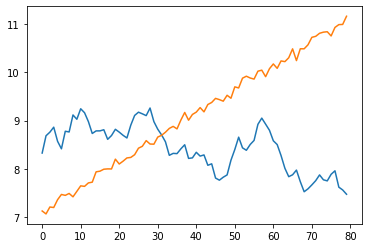

In [5]:
# Plot traces.
plt.plot(df_diff['time_s'], df_diff['x_kbp'])
plt.plot(df_moving['time_s'], df_moving['x_kbp'])
plt.show()
plt.close()

In [6]:
# Calculate alphas.
print('Diffusive exponent:', get_anom_diff_fit(df_diff['x_kbp'], 1/frames_per_second, measurement_error)[1])
print('Moving exponent:', get_anom_diff_fit(df_moving['x_kbp'], 1/frames_per_second, measurement_error)[1])

Diffusive exponent: 0.7884035097895015
Moving exponent: 1.9999999999999982
